Ubiquitous imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use(['seaborn-ticks', 'seaborn-talk'])

import numpy as np
import pandas as pd
import xarray as xr

import seaborn as sns

/Users/daniel/anaconda/lib/python3.5/site-packages/xarray/core/formatting.py:16: FutureWarning: The pandas.tslib module is deprecated and will be removed in a future version.
  from pandas.tslib import OutOfBoundsDatetime


# Introduction

This notebook is just a quick exploration of the sample dataset made available as part of the [Planet](https://www.kaggle.com/c/planet-understanding-the-amazon-from-space/data) kaggle competition.

The sample testing dataset has three components:

- `train-jpg-sample/*.jpg` - Reference images produced by Planet corresponding to the raw RGB data to be analyzed
- `train-tif-sample/*.tif` - [GeoTiff](https://en.wikipedia.org/wiki/GeoTIFF) format "chips" [taken from Planet's satellite constellation](https://www.kaggle.com/c/planet-understanding-the-amazon-from-space/data), with R/G/B/IR channels; all the data for each channel is in a 16-bit digital number format. Each pixel is orthorectified to a resolution of 3m
- `train.csv` - training filenames and labels

It's easiest to peak into the labels first.

In [2]:
import pandas as pd

labels_raw = pd.read_csv("../../planet/train.csv")
labels_raw.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


However, we really only care about the labels for the files which we have. So we can quickly extract those based on the filenames in one of our `train-*-sample/` folders.

In [10]:
import os
import glob

def get_fn(pth):
    base = os.path.basename(pth)
    fn, ext = os.path.splitext(base)
    return fn

fns = map(get_fn, 
          # glob.glob("../../planet/train-tif-sample/*.tif"))
          glob.glob("../../planet/train-tif-v2/*.tif"))
fns = list(fns)
print(fns[:5])

['train_0', 'train_1', 'train_10', 'train_100', 'train_1000']


In [11]:
labels_subset = labels_raw.loc[labels_raw.image_name.isin(fns)]
labels_subset.head(15)

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road
5,train_5,haze primary water
6,train_6,agriculture clear cultivation primary water
7,train_7,haze primary
8,train_8,agriculture clear cultivation primary
9,train_9,agriculture clear cultivation primary road


We need to process these labels a *bit* more -

1. We need to map the image ID numbers to the order they will be read in later; this is just a matter of preseriving the existing index and then re-indexing

2. The values in **tags** is actually a space-delimited list corresponding to all the possible tags. We should probably turn this into a matrix of features with binary encoding

In [13]:
labels_re_indexed = (
    labels_subset
        .reset_index()
        .rename(columns={'index': 'id'})
)

In [14]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()

tags = labels_subset.tags.apply(lambda x: x.split(' '))
encoding = mlb.fit_transform(tags)
classes = mlb.classes_

tags_encoded = pd.DataFrame(encoding, columns=classes, dtype=np.byte)

Now we can merge the two together since they have a common index based on our pre-processing.

In [15]:
labels_proc = pd.concat([labels_re_indexed, tags_encoded], axis=1)
labels_proc.head(10)

,id,image_name,tags,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water
0,0,train_0,haze primary,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
1,1,train_1,agriculture clear primary water,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1
2,2,train_2,clear primary,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
3,3,train_3,clear primary,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,4,train_4,agriculture clear habitation primary road,1,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,0
5,5,train_5,haze primary water,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1
6,6,train_6,agriculture clear cultivation primary water,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1
7,7,train_7,haze primary,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
8,8,train_8,agriculture clear cultivation primary,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0
9,9,train_9,agriculture clear cultivation primary road,1,0,0,0,0,1,0,0,1,0,0,0,1,1,0,0,0


Serialize the new encoded labels to disk.

In [19]:
import feather

feather.write_dataframe(labels_proc,
                        "../../planet/train.encoded.feather")
labels_proc.to_csv("../../planet/train.encoded.csv", index=False)

One last useful tidbit - it might be nice to havea few examples of chips where only a single feature is present. That's super easy to extract from the encoded tags, we just need to sum up the values for each tag indicator column and compare to 1.

In [9]:
labels_proc['is_unique'] = labels_proc[classes].sum(axis=1) == 1
labels_proc.loc[labels_proc.is_unique]

,id,image_name,tags,agriculture,artisinal_mine,bare_ground,clear,cloudy,cultivation,habitation,haze,partly_cloudy,primary,road,slash_burn,water,is_unique
34,10021,train_10021,cloudy,0,0,0,0,1,0,0,0,0,0,0,0,0,True
56,10043,train_10043,cloudy,0,0,0,0,1,0,0,0,0,0,0,0,0,True
83,10070,train_10070,cloudy,0,0,0,0,1,0,0,0,0,0,0,0,0,True
94,10081,train_10081,cloudy,0,0,0,0,1,0,0,0,0,0,0,0,0,True


---

Since these are GeoTiff files, my first instinct is to see what sort of metadata they might have. The typical tool I use to work with this format of data is [rasterio](https://github.com/mapbox/rasterio), so let's load a sample file and see what's in it:

In [20]:
import rasterio

fn = '../../planet/train-tif-sample/train_10001.tif'
fn_jpg = fn.replace("tif", "jpg")

with rasterio.open(fn) as f:
    r, g, b, ir = f.read()
    profile = f.profile
    
print(profile)

{'tiled': False, 'count': 4, 'width': 256, 'transform': Affine(1.0, 0.0, 0.0,
       0.0, 1.0, 0.0), 'crs': CRS({}), 'interleave': 'pixel', 'driver': 'GTiff', 'height': 256, 'dtype': 'uint16', 'nodata': None}


/Users/daniel/anaconda/lib/python3.5/site-packages/rasterio/__init__.py:282: NotGeoreferencedWarning: Dataset has no geotransform set. Default transform will be applied (Affine.identity())
  s.start()


So this is about less than useless; we have no metadata whatsoever to work with, and the GeoTiff data is really just four stacked arrays. A slightly easier approach is to read in the data as an array using [scikit-image](http://scikit-image.org/).

In [21]:
from skimage.io import imread

img = imread(fn)
img.shape

(256, 256, 4)

Comparing all four channels versus the reference JPG provided.

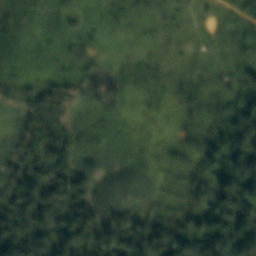

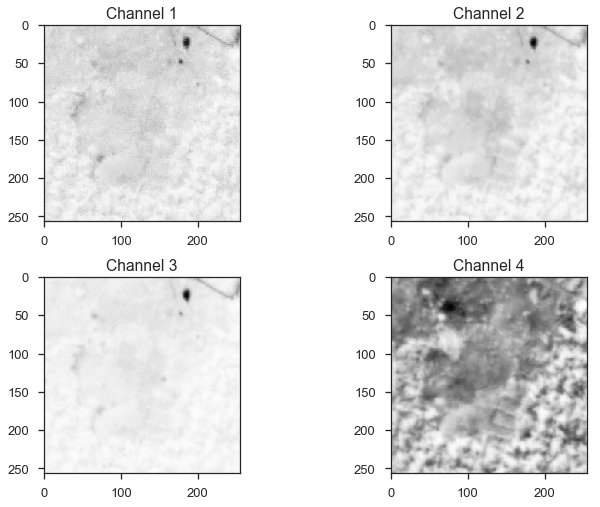

In [22]:
fig, axs = plt.subplots(2, 2, subplot_kw={'aspect': 'equal'})

for i, ax in enumerate(axs.flatten()):
    ax.imshow(img[..., i])
    ax.set_title("Channel {:d}".format(i+1))
plt.tight_layout()

from IPython.display import Image
Image(fn_jpg)

---

This sample dataset is very small, but ideally we'll need to scale up to a very large version (10's of GB). This isn't quite a "big data" problem, but it's enough that I can't stream all the data through memory at once on my laptop. The easiest way to handle this situation is to use [dask](http://dask.pydata.org/en/latest/) to ingest the data and process it out-of-core. 

To do this, we have to build a crude pipeline to ingest the data. In this case, this is actually very easy - we can just wrap the `skimage.io.read()` method before in dask's `delayed()` operator, which essentially binds a call to the function with a contract to perform the operation at some future time. From each of these contracts, we can create a 3D array based on the details of our sentinel image from before, again in an asynchronous or delayed context. Finally, we stack along a new prepended axis.

In [30]:
import dask.array as da
from dask import delayed

del_imread = delayed(imread, pure=True)

# Assemble a list of files in the same order that we read in 
# the filenames earlier; this give us a mapping index to match
# with labels.
tif_fns = ["../../planet/train-tif-sample/{}.tif".format(fn)
           for fn in fns]
ids = map(lambda x: int(x.split("_")[1]), fns)

lazy_tifs = [del_imread(fn) for fn in tif_fns]

# Construct delayed (dask) arrays from the tiffs we read in, using
# our original example ('img') as a sentinel to infer datatype and shape
arrays = [da.from_delayed(lazy_tif, dtype=img.dtype, shape=img.shape)
          for lazy_tif in lazy_tifs]

# Stack along a prepended axis
stacked = da.stack(arrays, axis=0)

print(stacked)

dask.array<stack, shape=(100, 256, 256, 4), dtype=uint16, chunksize=(1, 256, 256, 4)>


## Feed into xarray

In [31]:
import xarray as xr

nidx, nx, ny, _ = stacked.shape

# Constract a Dataset based on the RGB-IR fields
kaggle_ds = xr.Dataset()
kaggle_ds['idx'] = (['idx', ], list(ids))
kaggle_ds['x'] = (['x', ], range(nx))
kaggle_ds['y'] = (['y', ], range(ny))
kaggle_ds['red'] = (['idx', 'x', 'y'], stacked[...,0].astype('float'))
kaggle_ds['blue'] = (['idx', 'x', 'y'], stacked[...,1].astype('float'))
kaggle_ds['green'] = (['idx', 'x', 'y'], stacked[...,2].astype('float'))
kaggle_ds['nir'] = (['idx', 'x', 'y'], stacked[...,3].astype('float'))
kaggle_ds['ndvi'] = (kaggle_ds.nir - kaggle_ds.red) / (kaggle_ds.nir + kaggle_ds.red)

ds = kaggle_ds

/Users/daniel/anaconda/lib/python3.5/site-packages/dask/array/core.py:476: RuntimeWarning: overflow encountered in true_divide
  o = func(*args, **kwargs)


In [32]:
# Merge onto the labels

labels_ds = (
    labels_proc
    .rename(columns={'id': 'idx'})
    .set_index('idx')
    .drop(['image_name', 'tags'], axis=1)
    .to_xarray()
)
combined_ds = xr.auto_combine([ds, labels_ds])

In [33]:
combined_ds.to_netcdf("training_data.labeled.nc")
ds = combined_ds.load()

syncing


/Users/daniel/anaconda/lib/python3.5/site-packages/dask/async.py:247: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)


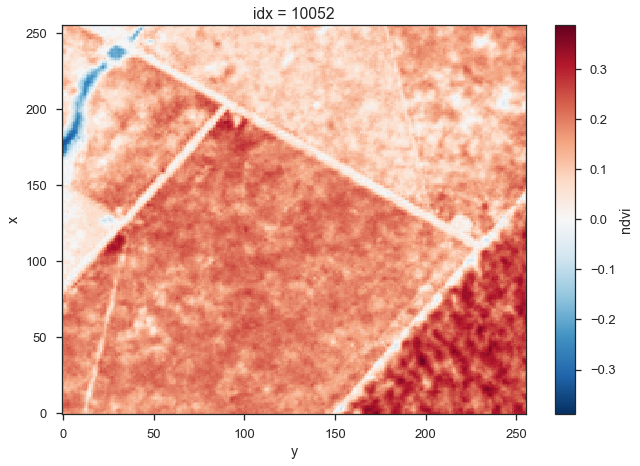

In [34]:
ds.sel(idx=10052).ndvi.plot.imshow(center=0, cmap='RdBu_r')

This is an efficient way to read in and process the data; nothing actually is executed until we explicitly need to do so, and we can re-chunk and subset the data in any manner that might help to limit the amount to be read in at any given time. 

Furthermore, we can ingest into any more complex analysis pipeline. [Here is a blogpost by the main dask author exploring interfaces with TensorFlow](http://matthewrocklin.com/blog/work/2017/02/11/dask-tensorflow).

# Feature Processing

## Blob Detection

E.g. from [skimage docs](http://scikit-image.org/docs/dev/auto_examples/features_detection/plot_blob.html#sphx-glr-auto-examples-features-detection-plot-blob-py)

In [2]:
from skimage.feature import blob_doh, blob_dog, blob_log
from skimage.color import rgb2gray

(23, 10010, 23    clear primary water
Name: tags, dtype: object)
(256, 256, 4)
(256, 256)


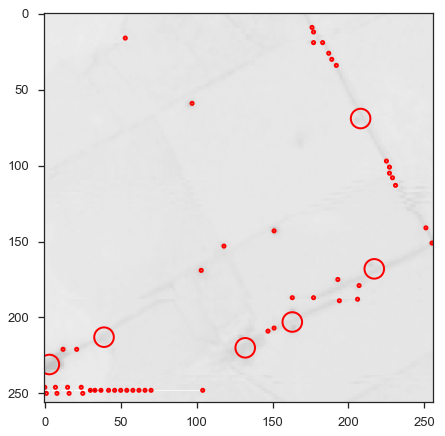

In [19]:
id = 10010
row = labels_proc[labels_proc.id == id]
ix = int(row.index.values)
print(ix, id, row.tags)
image = stacked[ix]
print(image.shape)
gray = rgb2gray(image[..., :-1])
print(gray.shape)

fig, ax  = plt.subplots()
ax.imshow(gray)

blobs = blob_log(gray, threshold=0.01)
for blob in blobs:
    y, x, r = blob
    c = plt.Circle((x, y), r, color='r', linewidth=2,
                   fill=False)
    ax.add_patch(c)

## Edge Detection

Using a [Sobel filter](http://scikit-image.org/docs/dev/api/skimage.filters.html#skimage.filters.sobel), can we detect roads?

In [106]:
CHANNELS = ['red', 'blue', 'green', 'nir']
CHANNELSP = CHANNELS + ['ndvi', ]

def _to_channels(da):
    return np.stack([sample[c].values 
                     for c in ['red', 'blue', 'green', 'nir']], axis=-1)
    

sample = ds.sel(idx=10035)
x = _to_channels(sample)

In [107]:
from skimage.filters import sobel

def _sobel_channels(sample):
    sample_sobel = sample.copy()
    for c in CHANNELSP:
        sample_sobel[c].values = sobel(sample[c])
    return sample_sobel
sample_sobel = _sobel_channels(sample)

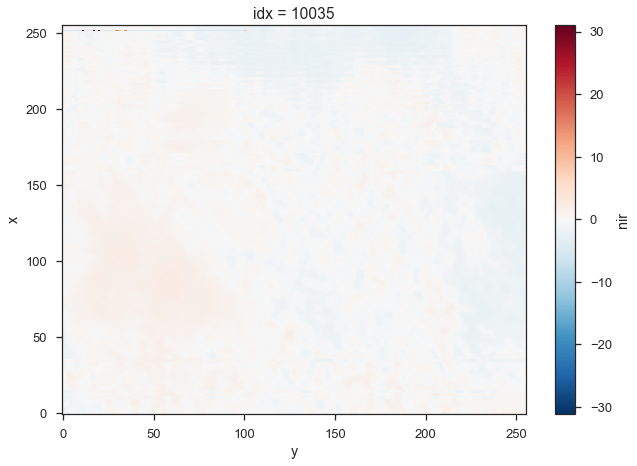

In [117]:
def _n(x):
    return (x - x.mean())/x.std()

_n(sample.nir).plot.imshow(center=0)

In [38]:
x = [_sobel_channels(ds.isel(idx=i)) for i in range(len(ds.idx))]
sobel_ds = xr.concat(x, 'idx')
sobel_ds.to_netcdf("train.sobel.nc")

syncing


---

In [64]:
import numpy.fft as nfft
sample = sobel_ds.isel(idx=37)


df = {}
for channel in CHANNELSP:
    _x = sample[channel]

    res = nfft.fft2(_x)
    y = nfft.fftshift(np.abs(res))
    np.mean(y), np.std(y)
    
    # Down-sample just one quadrant
    n = y.shape[0]
    yi = y[:n//2, n//2:]
    
    print(channel, yi.mean(), yi.std())

red 13201.1303001 18274.3514398
blue 11743.1648133 17349.4618884
green 11177.7532194 16157.7213796
nir 32305.3759839 52148.8633993
ndvi 2.58699657981 4.37137144705


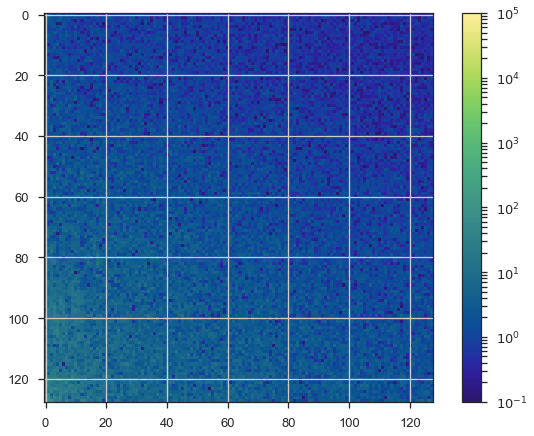

In [56]:
from matplotlib.colors import LogNorm
import cmocean

# y = np.sqrt((res * np.conj(res)).real)
plt.imshow(yi, norm=LogNorm(1e-1, 100000),
           cmap=cmocean.cm.haline)
plt.colorbar()
plt.grid()



<xarray.Dataset>
Dimensions:         (x: 256, y: 256)
Coordinates:
    idx             int64 10024
  * x               (x) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
  * y               (y) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
Data variables:
    red             (x, y) float64 4.03e+03 4.1e+03 4e+03 4.028e+03 ...
    blue            (x, y) float64 3.423e+03 3.466e+03 3.446e+03 3.474e+03 ...
    green           (x, y) float64 2.207e+03 2.226e+03 2.183e+03 2.198e+03 ...
    nir             (x, y) float64 7.681e+03 7.758e+03 7.593e+03 7.38e+03 ...
    ndvi            (x, y) float64 0.3118 0.3085 0.3099 0.2938 0.2809 0.2733 ...
    agriculture     int8 0
    artisinal_mine  int8 0
    bare_ground     int8 0
    clear           int8 0
    cloudy          int8 0
    cultivation     int8 0
    habitation      int8 0
    haze            int8 0
    partly_cloudy   int8 1
    primary         int8 1
    road            int8 0
    slash_burn      int8 0
    water 

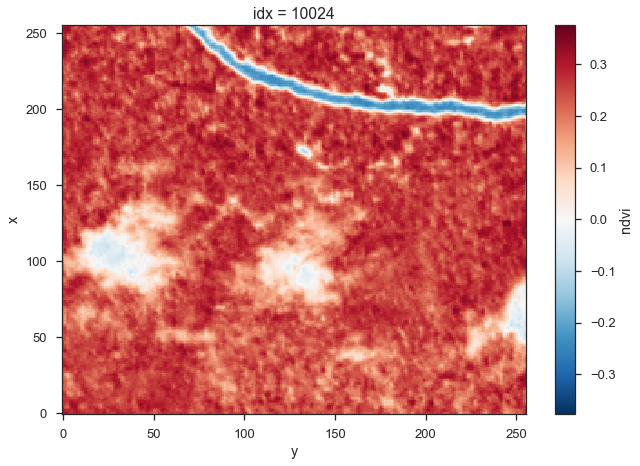

In [41]:
a = ds.isel(idx=37)#.ndvi
print(a)
a.ndvi.plot.imshow()

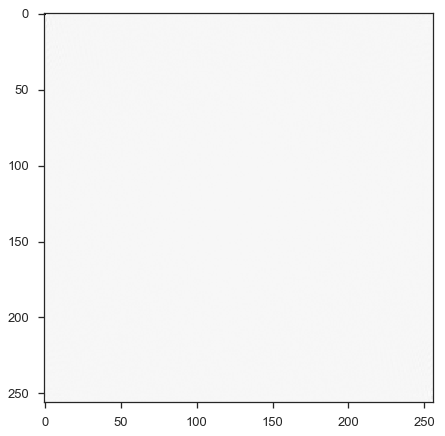

In [42]:
plt.imshow(res.real)

## Down-sampling and Transformation

In [65]:
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection)

digits = datasets.load_digits(n_class=6)

In [68]:
digits.data.shape

(1083, 64)

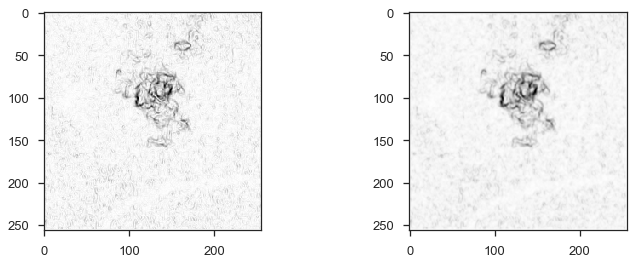

In [72]:
from scipy import ndimage

k = np.array([[1, 2, 1], [2, 4, 1], [1, 2, 1]])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 4))

_x = sample.red

ax1.imshow(_x)
ax2.imshow(ndimage.convolve(_x, k))

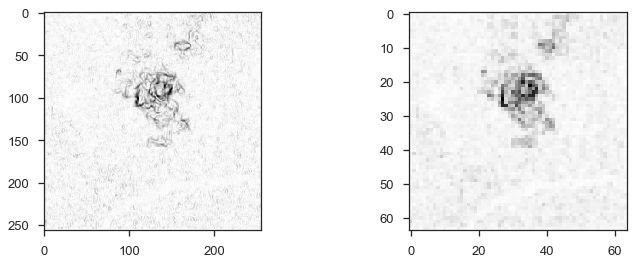

In [80]:
from skimage.transform import downscale_local_mean

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 4))

_x = sample.red
n = _x.shape[0]
s = 2 ** 2

ax1.imshow(_x)
ax2.imshow(downscale_local_mean(_x, (s, s)))

## Sobel + Blur

/Users/daniel/anaconda/lib/python3.5/site-packages/xarray/core/variable.py:1143: RuntimeWarning: invalid value encountered in true_divide
  if not reflexive


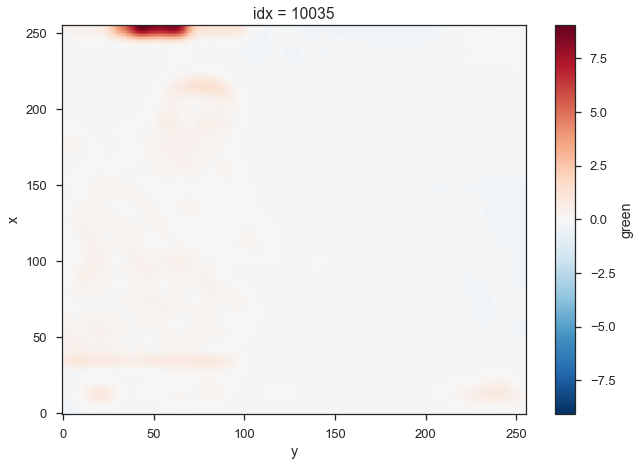

In [144]:
from skimage.filters import gaussian

sample = sobel_ds.sel(idx=10035)

def _normalize(x):
    return (x-x.mean())/x.std()

def _gaussian_channels(sample, **kwargs):
    sample_gaussian = sample.copy()
    for c in CHANNELSP:
        sample_gaussian[c].values = gaussian(sample[c], **kwargs)
    return sample_gaussian

sample_gaussian = _gaussian_channels(_normalize(sample), 
                                     sigma=4, mode='reflect')
sample_gaussian.green.plot.imshow()

http://justinbois.github.io/bootcamp/2016/lessons/l38_intro_to_image_processing.html
http://bi1x.caltech.edu/2015/tutorials/image_processing_2.html